<a id="top"></a>
# Long Period TESS Targets with Kepler Counterparts
***


## Prerequisites
- Python syntax
- Something about exoplanet transits, link to free resource

## Learning Goals

By the end of this tutorial, you will:

- 

To use as a guideline:
"Set a minimum threshold for orbital period (should be long-period orbits, greater than 6mos). Find all TESS 20-seconds targets that have data for these Kepler TCEs to create an even longer baseline."

## Introduction
The [Kepler initial and follow-on (K2) missions confirmed over 2,600 exoplanets](https://exoplanets.nasa.gov/keplerscience/) and contributed to an unprecedented exposion of knowledge about planetary systems in our galaxy. In addition to confirmed exoplanets, Kepler identified thousands more potential planetary candidates, referred to as Kepler Objects on Interest (KOI's). 

The Transiting Exoplanet Survey Satellite (TESS) began its observations just before the completion of the K2 mission; there may be long-period (greater than 6 months) exoplanets whose transits were observed by both missions. By combining observations from both missions, we could potentially view multiple transits and confirm the existence of new exoplanets. 

Possible transits observed by Kepler are called Threshold Crossing Events, or TCEs. More specifically, according to the [NASA Exoplanet Archive documentation](https://exoplanetarchive.ipac.caltech.edu/docs/Kepler_TCE_docs.html), 

>"A Threshold-Crossing Event (TCE) is a sequence of transit-like features in the flux time series of a given target that resembles the signature of a transiting planet to a sufficient degree that the target is passed on for further analysis."

NOT UPDATED: The workflow for this notebook consists of:
* [Main Content](#Main-Content)
    * [Loading Data](#Loading-Data)
    * [File and Data Information](#File-and-Data-Information)
* [Visualization](#Visualization)
* [Exercises](#Exercises)
* [Additional Resources](#Additional-Resources)

## Imports
Describe the main packages we're using here and their use-case for this notebook. If there's something unusual, explain what the library is, and why we need it.
- *numpy* to handle array functions
- *astropy.io fits* for accessing FITS files
- *astropy.table Table* for creating tidy tables of the data
- *matplotlib.pyplot* for plotting data

In [80]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

from astropy.io import fits
from astropy.table import Table
from astroquery.mast import Mast
from astroquery.mast import Observations


# Added by JRK
import requests
from astropy.io import ascii
import lightkurve as lk
import astropy.units as u # May not end up using?

***

## Load full table of Kepler Threshold Crossing Events, or TCEs and filter by period

The NASA Exoplanet Archive hosts many useful data tables, including the list of [Threshold Crossing Events (TCEs)](https://exoplanetarchive.ipac.caltech.edu/docs/program_interfaces.html#tce). We'll use the Quarter 1 through Quarter 17 Data Release 24 (DR24) version. These TCEs were evaluated by an autovetter, a machine-learning program that classified TCEs into three categories: PC (Planet Candidate), AFP (Astrophysical False Positive), and NTP (Non-Transiting Phenomenon). More information about the autovetter can be found in [McCauliff et al. 2015 ApJ 806, 6](https://ui.adsabs.harvard.edu/abs/2015ApJ...806....6M/abstract).

We can point the astropy Table reader to a URL that contains the data table.

In [40]:
# Load the TCE DR24 table as an astropy table and view a preview.
# JRK For some reason, this worked earlier, and now does not. Downloaded a copy of the dr24 version and loaded it locally. Not ideal.
#tab=Table.read('https://exoplanetarchive.ipac.caltech.edu/cgi-bin/nstedAPI/nph-nstedAPI?table=q1_q17_dr24_tce',format='ascii.csv')
tab=Table.read('./q1_q17_dr24_tce_2023.05.29_11.07.52.csv',format='ascii.csv',comment='#')
#print('Length of full TCE table: ',len(tab))
tab.pprint()

rowid  kepid   tce_plnt_num ... tce_dikco_msky tce_dikco_msky_err
----- -------- ------------ ... -------------- ------------------
    1  1162345            2 ...        0.46282                1.1
    2  1292087            2 ...        0.22049               0.22
    3  1293031            2 ...        0.41872              0.207
    4  1162345            3 ...        0.13742              0.196
    5  1164109            1 ...         15.207             0.0893
    6   757450            1 ...        0.12498             0.0763
    7   892667            1 ...        0.18106              0.124
    8   892772            1 ...         5.2002              0.165
    9  1026032            1 ...       0.064587              0.077
   10  1026032            2 ...        0.13865              0.084
  ...      ...          ... ...            ...                ...
20357 11809346            1 ...       0.090355             0.0786
20358 11826440            2 ...        0.58446              0.755
20359 1185

The NASA Exoplanet Archive provides detailed information about the [Data Columns in the Kepler TCE Table](https://exoplanetarchive.ipac.caltech.edu/docs/API_tce_columns.html). Some of the most important columns for us will be:
- kepid, Kepler identification number, which we can use when searching the MAST Archive.
- tce_period, the orbital period in days.
- av_pred_class, the autovetter predicted classification (PC, AFP, or NTP)

We'd like to filter our table to only include Planetary Candidates of with a TCE period of greater than 6 months, or 180 days.

In [41]:
# Only include those that autovetter indicates as "PC" for Planetary Candidate
tab=tab[tab['av_pred_class']=='PC']
print('Number of Kepler TCEs marked as Planetary Candidates:',len(tab))

Number of Kepler TCEs marked as Planetary Candidates: 3900


We can see that of the over 20,000 TCEs, just under 20% were identified as likely planetary candidates. 
What is the distribution of the periods of those PCs? We can view a histogram of the 'tce_period' column.

Text(0, 0.5, 'Number of PCs')

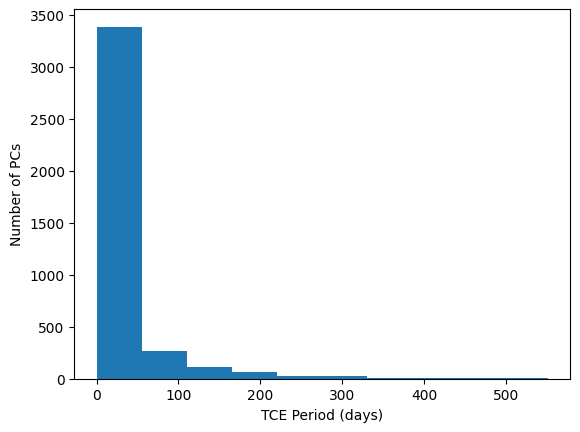

In [42]:
plt.hist(tab['tce_period'])
plt.xlabel('TCE Period (days)')
plt.ylabel('Number of PCs')

The vast majority of the TCE periods are fewer than 50 days. The planetary candidates that would most benefit from the long baseline afforded by combining the Kepler, K2, and TESS datasets are those with longer periods. Here, we'll again filter our table to just include those PCs with periods of greater than 6 months, or 180 days. 

In [43]:
# Only include those table rows with TCE period greater than 180 days
tab=tab[tab['tce_period']>180]
print('Number of Kepler TCEs marked PC and period > 180 days:',len(tab))

Number of Kepler TCEs marked PC and period > 180 days: 123


## Find all TESS 20-second targets for these Kepler TCEs
The Kepler and K2 missions studied a limited portion of the sky, but TESS has studied (and continues to study) the full sky. This means that all Kepler and K2 identifications are likely to be included in the TESS Catalog. However, they may not all 

JRK what is the science reason for only 20-second targets? Why not also 2 min? Clearly 30 min not frequent enough.

### Finding all observations in the MAST archive by the Kepler ID number
When we use astroquery.mast's Observations.query_object or query_object_count functions, the object's name will be resolved into sky coordinates (RA and Dec), so that all observations of that coordinate will be returned. This allows us to search by the Kepler ID column, even though TESS will not have used the Kepler ID to refer to the name of the target. Likewise, other ways to search the MAST archive, such as query_criteria, will also resolve the coordinates of the name input to 'objectname'. See the [astroquery documentation about MAST Queries](https://astroquery.readthedocs.io/en/latest/mast/mast.html) for more information. Let's illustrate this point with the first row in our filtered table. 

In [61]:
i=0
row=tab[i]
print('Kepler ID of the first row in our table: ',str(row['kepid']))

Kepler ID of the first row in our table:  2581316


In [54]:
# Query all observations in MAST that correspond to the coordinates of this Kepler ID, within 1 arcsecond.
obs_table = Observations.query_object('KIC '+str(row['kepid']),radius=1*u.arcsec)

In [55]:
# View the observation table
obs_table.pprint()

intentType obs_collection provenance_name ... srcDen   obsid   distance
---------- -------------- --------------- ... ------ --------- --------
   science           TESS            SPOC ...    nan  27463635      0.0
   science           TESS            SPOC ...    nan  62431369      0.0
   science           TESS            SPOC ...    nan  62870781      0.0
   science           TESS            SPOC ...    nan  92616912      0.0
   science           TESS            SPOC ...    nan  95133363      0.0
   science           TESS            SPOC ...    nan  62349937      0.0
   science           TESS            SPOC ...    nan  62793303      0.0
   science           TESS            SPOC ...    nan  91547081      0.0
   science           TESS            SPOC ...    nan  93772051      0.0
   science    SPITZER_SHA    SSC Pipeline ...    nan   1730213      0.0
       ...            ...             ... ...    ...       ...      ...
   science           HLSP             QLP ...    nan 129964724  

In [56]:
# View all unique entries in the 'target_name' column
np.unique(obs_table['target_name'])

137685450
2144.049
Kepler10-1-2-1-1-1-1-1
--
TESS FFI
TICA FFI
kplr002581316


From the above, we can see that inputting an 'objectname' of 'KIC 2581316' from the Kepler Input Catalog (KIC) identification number, we find all the observations of that target from all different missions - even if they did not specifically refer to the name of the target by it.

### Finding counts of TESS 20-second targets
To examine each of the 123 long-period planetary candidates that were also TESS 20-second targets, it is more efficient to just query MAST for the counts (total numbers) of observations that match our criteria. 
JRK is this true - time it. 

In [97]:
%%time
obs_table = Observations.query_criteria(objectname='KIC '+str(row['kepid']),radius=1*u.arcsec,
                                        project='TESS',obs_collection='HLSP',
                                       t_exptime=[20.0,120.0]) # If do obs_collection= TESS, get 35. QLP, 0. SPOC, 0. HLSP tons.

CPU times: user 34.4 ms, sys: 182 µs, total: 34.6 ms
Wall time: 172 ms


In [ ]:
tab.add_column(False,name='TESS fast')

In [100]:
for i,row in enumerate(tab):
    # Will resolve Kepler ID name to a coordinate and search that
    obs_table = Observations.query_criteria(objectname='KIC '+str(row['kepid']),radius=1*u.arcsec,
                                        project='TESS',obs_collection='HLSP',
                                       t_exptime=[20.0,120.0])
    if len(obs_table)>0: tab['TESS fast'][i]=True
    print(i,tab['TESS fast'][i])
np.sum(tab['TESS fast'])

0 False
1 False
2 False
3 False
4 False
5 False
6 False
7 False
8 False
9 False
10 False
11 False
12 False
13 False
14 False
15 False
16 False
17 False
18 False
19 False
20 False
21 False
22 False
23 False
24 False
25 False
26 False
27 False
28 False
29 False
30 False
31 False
32 False
33 False
34 False
35 False
36 False
37 False
38 False
39 False
40 False
41 False
42 False
43 False
44 True
45 False
46 False
47 False
48 False
49 False
50 False
51 False
52 False
53 False
54 True
55 False
56 False
57 False
58 False
59 False
60 False
61 False
62 False
63 False
64 False
65 False
66 False
67 False
68 True
69 False
70 False
71 False
72 False
73 False
74 False
75 False
76 False
77 False
78 False
79 False
80 False
81 False
82 False
83 False
84 False
85 False
86 False
87 False
88 False
89 False
90 False
91 False
92 False
93 False
94 False
95 False
96 False
97 False
98 False
99 False
100 False
101 False
102 False
103 False
104 False
105 False
106 False
107 False
108 True
109 False
110 False
111 

5

In [104]:
tab[tab['TESS fast']==True]['kepid','tce_period','tce_period_err','tce_num_transits']

kepid,tce_period,tce_period_err,tce_num_transits
int64,float64,float64,int64
8056665,207.587,0.000719409,6
7768451,192.667,0.000860441,7
8264402,215.954,0.00177961,7
10850327,440.164,0.00518516,3
12644769,451.773,8.60856e-05,4


# Examine the combined light curves for one target

In [73]:
search_result=lk.search_lightcurve(1164109) # Works if it's input as an integer.
#search_result=lk.search_lightcurve('KIC '+str(1164109)) # Only returns Kepler light kurves.
# 291.65265, 36.89502
#search_result=lk.search_lightcurve('291.65265, 36.89502')
search_result

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,Kepler Quarter 00,2009,Kepler,1800,kplr001164109,0.0
1,Kepler Quarter 01,2009,Kepler,1800,kplr001164109,0.0
2,Kepler Quarter 02,2009,Kepler,60,kplr001164109,0.0
3,Kepler Quarter 02,2009,Kepler,1800,kplr001164109,0.0
4,Kepler Quarter 03,2009,Kepler,1800,kplr001164109,0.0
5,Kepler Quarter 04,2010,Kepler,1800,kplr001164109,0.0
6,Kepler Quarter 05,2010,Kepler,1800,kplr001164109,0.0
7,Kepler Quarter 06,2010,Kepler,1800,kplr001164109,0.0
8,Kepler Quarter 07,2010,Kepler,1800,kplr001164109,0.0


In [131]:
search_result=lk.search_lightcurve(8056665,exptime='short')
search_result

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,Kepler Quarter 03,2009,Kepler,60,kplr008056665,0.0
1,Kepler Quarter 03,2009,Kepler,60,kplr008056665,0.0
2,Kepler Quarter 03,2009,Kepler,60,kplr008056665,0.0
3,Kepler Quarter 04,2010,Kepler,60,kplr008056665,0.0
4,Kepler Quarter 04,2010,Kepler,60,kplr008056665,0.0
5,Kepler Quarter 04,2010,Kepler,60,kplr008056665,0.0
6,Kepler Quarter 05,2010,Kepler,60,kplr008056665,0.0
7,Kepler Quarter 05,2010,Kepler,60,kplr008056665,0.0
8,Kepler Quarter 05,2010,Kepler,60,kplr008056665,0.0


In [132]:
# Load 'em all. Where does it "go"?
lc_collection = search_result.download_all()

<AxesSubplot:xlabel='Time - 2454833 [BKJD days]', ylabel='Normalized Flux'>

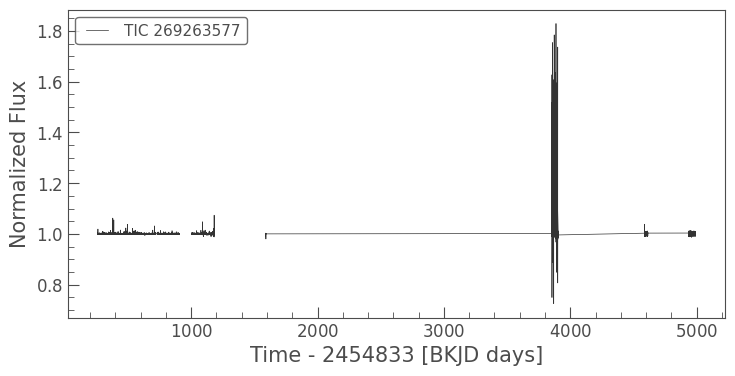

In [133]:
# Could be interesting to visualize just Kepler, then just TESS, then combined.
lc_stitched = lc_collection.stitch()
lc_stitched.plot()

Where possible (if the code supports it), use code examples that visually display the data in the tutorial. For example, if you are showing an object such as a Table, display a preview of the table:

## Exercises
Exercises are optional, but encouraged. Exercises can be woven into the main content of your tutorial, or appear in their own section toward the end of the tutorial. Final exercises can be more challenging, similar to homework problems. They can be minimal or take as long as 30 minutes to an hour to complete. If you do have one or more exercises in your tutorial, be sure to leave a blank code cell underneath each to show the reader that they're meant to try out their new skill right there. You may also want to include a "solutions" notebook next to your main notebook for the reader to check their work after they have finished their attempt.

## Additional Resources

This section is optional. Try to weave resource links into the main content of your tutorial so that they are falling in line with the context of your writing. For resources that do not fit cleanly into your narrative, you may include an additional resources section at the end of your tutorial. Usually a list of links using Markdown bullet list plus link format is appropriate:

- [MAST API](https://mast.stsci.edu/api/v0/index.html)
- [Kepler Archive Page (MAST)](https://archive.stsci.edu/kepler/)
- [Kepler Archive Manual](https://archive.stsci.edu/kepler/manuals/archive_manual.pdf)
- [Exo.MAST website](https://exo.mast.stsci.edu/)

## Citations
Provide your reader with guidelines on how to cite open source software and other resources in their own published work.

```
If you use `astropy` or `lightkurve` for published research, please cite the
authors. Follow these links for more information about citing `astropy` and
`lightkurve`:

* [Citing `astropy`](https://www.astropy.org/acknowledging.html)
* [Citing `lightkurve`](http://docs.lightkurve.org/about/citing.html)

```

## About this Notebook
Let the world know who the author of this great tutorial is! If possible and appropriate, include a contact email address for users who might need support (for example, `archive@stsci.edu`). You can also optionally include keywords, your funding source, or a last update date in this section.

**Author(s):** Jessie Blogs, Jenny V. Medina, Thomas Dutkiewicz <br>
**Keyword(s):** Tutorial, lightkurve, kepler, introduction, template <br>
**Last Updated:** Aug 2022 <br>
**Next Review:** Mar 2023
***
[Top of Page](#top)
<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/> 